In [1]:
from typing import Literal
from typing_extensions import TypedDict
from typing import Annotated

from langchain_community.tools import DuckDuckGoSearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import MessagesState, END
from langgraph.types import Command

from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent

In [2]:
search_tool = DuckDuckGoSearchResults(max_results=5)


# This executes code locally, which can be unsafe
repl = PythonREPL()


@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code and do math. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return result_str

In [3]:
members = ["researcher", "coder"]
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = members + ["FINISH"]

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal[*options]


llm = ChatGoogleGenerativeAI(
    #model="gemini-1.5-pro",
    model="gemini-2.0-flash",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    # other params...
)

class State(MessagesState):
    next: str


def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    if goto == "FINISH":
        goto = END

    return Command(goto=goto, update={"next": goto})

In [4]:



research_agent = create_react_agent(
    llm, tools=[search_tool], prompt="You are a researcher. DO NOT do any math."
)


def research_node(state: State) -> Command[Literal["supervisor"]]:
    result = research_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="researcher")
            ]
        },
        goto="supervisor",
    )


# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION, WHICH CAN BE UNSAFE WHEN NOT SANDBOXED
code_agent = create_react_agent(llm, tools=[python_repl_tool])


def code_node(state: State) -> Command[Literal["supervisor"]]:
    result = code_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="coder")
            ]
        },
        goto="supervisor",
    )


builder = StateGraph(State)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("researcher", research_node)
builder.add_node("coder", code_node)
graph = builder.compile()

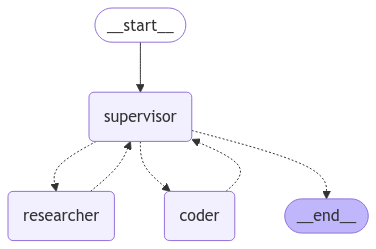

In [5]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
events = graph.stream(
    {
        "messages": [
            (
                "user",
                "First, get the UK's GDP over the past 5 years, then make a line chart of it. "
                "Once you make the chart, finish.",
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")

ValueError: no signature found for builtin type <class 'dict'>

In [ ]:


for s in graph.stream(
    {"messages": [("user", "What's the square root of 42?")]}, subgraphs=True
):
    print(s)
    print("----")

ValueError: no signature found for builtin type <class 'dict'>

In [5]:
messages = [
    (
        "system",
        "You are a helpful assistant that translates English to French. Translate the user sentence.",
    ),
    ("human", "I love programming."),
]
ai_msg = llm.invoke(messages)
ai_msg

AIMessage(content="J'adore la programmation.", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-7e782057-4ad4-463b-9c1b-1ba4e5c88404-0', usage_metadata={'input_tokens': 20, 'output_tokens': 7, 'total_tokens': 27, 'input_token_details': {'cache_read': 0}})

In [13]:
from smolagents import (
    CodeAgent,
    DuckDuckGoSearchTool,
    HfApiModel,
    ToolCallingAgent,
    VisitWebpageTool,
    LiteLLMModel,
    GradioUI,
)
import os
os.environ["GEMINI_API_KEY"]  = os.environ["GOOGLE_API_KEY"] 


# Let's setup the instrumentation first

# Then we run the agentic part!
#model = HfApiModel()
model = LiteLLMModel(model_id="gemini/gemini-2.0-flash")

search_agent = ToolCallingAgent(
    tools=[DuckDuckGoSearchTool(), VisitWebpageTool()],
    model=model,
    name="search_agent",
    description="This is an agent that can do web search.",
)

manager_agent = CodeAgent(
    tools=[],
    model=model,
    managed_agents=[search_agent],
)
#manager_agent.run("If the US keeps it 2024 growth rate, how many years would it take for the GDP to double?")

GradioUI(manager_agent).launch()

* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


Keyboard interruption in main thread... closing server.


In [1]:
import argparse
import os
import threading

from dotenv import load_dotenv
from huggingface_hub import login
from smolagents import (
    CodeAgent,
    # HfApiModel,
    LiteLLMModel,
    ToolCallingAgent,
    VisitWebpageTool,
    DuckDuckGoSearchTool,
    GradioUI,
)
import os


AUTHORIZED_IMPORTS = [
    "requests",
    "zipfile",
    "os",
    "pandas",
    "numpy",
    "sympy",
    "json",
    "bs4",
    "pubchempy",
    "xml",
    "yahoo_finance",
    "Bio",
    "sklearn",
    "scipy",
    "pydub",
    "io",
    "PIL",
    "chess",
    "PyPDF2",
    "pptx",
    "torch",
    "datetime",
    "fractions",
    "csv",
    "matplotlib",
    "seaborn",
]


append_answer_lock = threading.Lock()


def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument(
        "question", type=str, help="for example: 'How many studio albums did Mercedes Sosa release before 2007?'"
    )
    parser.add_argument("--model-id", type=str, default="o1")
    return parser.parse_args()


custom_role_conversions = {"tool-call": "assistant", "tool-response": "user"}

text_limit = 100000

os.environ["GEMINI_API_KEY"]  = os.environ["GOOGLE_API_KEY"] 
model = LiteLLMModel(
    "gemini/gemini-2.0-flash",
    custom_role_conversions=custom_role_conversions,
    max_completion_tokens=8192,
)

text_webbrowser_agent = ToolCallingAgent(
    model=model,
    tools=[DuckDuckGoSearchTool(), VisitWebpageTool()],
    max_steps=20,
    verbosity_level=2,
    planning_interval=4,
    name="search_agent",
    description="""A team member that will search the internet to answer your question.
Ask him for all your questions that require browsing the web.
Provide him as much context as possible, in particular if you need to search on a specific timeframe!
And don't hesitate to provide him with a complex search task, like finding a difference between two webpages.
Your request must be a real sentence, not a google search! Like "Find me this information (...)" rather than a few keywords.
""",
    provide_run_summary=True,
)
text_webbrowser_agent.prompt_templates["managed_agent"]["task"] += """You can navigate to .txt online files.
If a non-html page is in another format, especially .pdf or a Youtube video, use tool 'inspect_file_as_text' to inspect it.
Additionally, if after some searching you find out that you need more information to answer the question, you can use `final_answer` with your request for clarification as argument to request for more information."""

manager_agent = CodeAgent(
    model=model,
    tools=[],
    max_steps=12,
    verbosity_level=2,
    additional_authorized_imports=AUTHORIZED_IMPORTS,
    planning_interval=4,
    managed_agents=[text_webbrowser_agent],
)

GradioUI(manager_agent).launch()

* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ FInd the last 5 years of UK GDP then plot it as a line plot and display the image                               │
│                                                                                                                 │
╰─ LiteLLMModel - gemini/gemini-2.0-flash ────────────────────────────────────────────────────────────────────────╯

────────────────────────────────────────────────── Initial plan ───────────────────────────────────────────────────
Here is the plan of action that I will follow to solve the task:
                ```
                1.  Determine the current year.
2.  Calculate the last 5 years based on the current year.
3.  Search for UK GDP data for the calculated last 5 years using reliable sources like ONS, World Bank, or IMF.
4.  Structure the GDP data into a format suitable for plotting (e.g., lists or a Pandas DataFrame).
5.  Create a line plot of the GDP data using a Python plotting library (e.g., matplotlib, seaborn).
6.  Save the plot as an image file.
7.  Display the saved image.
8.  Present the image.


                ```

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Output message of the LLM: ────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                   
Thought: I will start by determining the current year using the `search_agent` tool.                               
Code:                                                                                                              
```py                                                                                                              
current_year = search_agent(task="What is the current year?")                                                      
print(current_year)                                                                                                
```                                                                                                                

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  current_year = search_agent(task="What is the current year?")                                                    
  print(current_year)                                                                                              
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

╭──────────────────────────────────────────── New run - search_agent ─────────────────────────────────────────────╮
│                                                                                                                 │
│ You're a helpful agent named 'search_agent'.                                                                    │
│ You have been submitted this task by your manager.                                                              │
│ ---                                                                                                             │
│ Task:                                                                                                           │
│ What is the current year?                                                                                       │
│ ---                                                                                                             │
│ You're helping your manager solve a wider task: so make sure to not provide a one-line answer, but give as much │
│ information as possible to give them a clear understanding of the answer.                                       │
│                                                                                                                 │
│ Your final_answer WILL HAVE to contain these parts:                                                             │
│ ### 1. Task outcome (short version):                                                                            │
│ ### 2. Task outcome (extremely detailed version):                                                               │
│ ### 3. Additional context (if relevant):                                                                        │
│                                                                                                                 │
│ Put all these in your final_answer tool, everything that you do not pass as an argument to final_answer will be │
│ lost.                                                                                                           │
│ And even if your task resolution is not successful, please return as much context as possible, so that your     │
│ manager can act upon this feedback.You can navigate to .txt online files.                                       │
│ If a non-html page is in another format, especially .pdf or a Youtube video, use tool 'inspect_file_as_text' to │
│ inspect it.                                                                                                     │
│ Additionally, if after some searching you find out that you need more information to answer the question, you   │
│ can use `final_answer` with your request for clarification as argument to request for more information.         │
│                                                                                                                 │
╰─ LiteLLMModel - gemini/gemini-2.0-flash ────────────────────────────────────────────────────────────────────────╯

────────────────────────────────────────────────── Initial plan ───────────────────────────────────────────────────
Here is the plan of action that I will follow to solve the task:
                ```
                1. Use the `web_search` tool to search for "current year".
2. Analyze the search results to identify a reliable source for the current year (e.g., a government website, 
reputable news organization, or time/date website).
3. Visit the identified reliable source using the `visit_webpage` tool to confirm the current year.
4. Formulate the answer in the required format, including:
    *   Task outcome (short version): stating the current year.
    *   Task outcome (extremely detailed version): describing the process of finding the current year using a 
search engine and confirming it with a reliable source.
    *   Additional context (if relevant): briefly discussing the relevance of the current year, if any, in a 
broader context.
5. Use the `final_answer` tool to provide the final answer.

\

                ```

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Calling tool: 'web_search' with arguments: {'query': 'current year'}                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Observations: ## Search Results

|Today's Date - CalendarDate.com](https://www.calendardate.com/todays.htm)
Details about today's date with count of days, weeks, and months, Sun and Moon cycles, Zodiac signs and holidays. 
Friday February 14, 2025 . Home; Calendars. 2025 Calendar; ... Current Season Today: Winter with 34 days until the 
start of Spring. S. Hemishpere flip seasons - i.e. Winter is Summer.

|What is the date today | Today's Date](https://www.datetoday.info/)
Find out the current date and time in different formats and time zones. Learn how many days are left in the week, 
month and year, and the week number and month number.

|Today's Date and Time - Date and Time Tools](https://todaysdatetime.com/)
Discover today's exact date and time, learn about time zones, date formats, and explore our comprehensive 
collection of date and time tools including calculators, converters, and calendars. Perfect for planning, 
scheduling, and time management.

|What Is Today's Date? - Inch Calculator](https://www.inchcalculator.com/what-is-todays-date/)
Therefore, this date could be unambiguously written as 2023-04-03, which represents April 3rd, 2023. More About 
Today's Date. Day of the Week: Sunday; Current Day Number: 40 of 365; Current Week Number: 6 of 52; Days Left in 
2025: 325 days; Weeks Left in 2025: 46 weeks and 3 days; Current Date on a Calendar

|Date and Time Today | Date and Time Now](https://datetimetoday.com/)
Check the current date and time for any location in the world. Find date, time, timezone and more for over 200 
countries. ... Check the current date and time for any location in the world. Find date, time, timezone and more 
for over 200 countries. DateTimeToday.Com Dark Mode. Los Angeles. Friday, February 14, 2025. 02:23:13 PM. New York.
Fri ...

|What Is Today's Date? - The time calculator](https://thetimecalculator.org/today-date)
Find out the date and the current year based on your location and time zone. Learn how to write the date in 
different formats and how to calculate the week number and remaining days in the year.

|timeanddate.com](https://www.timeanddate.com/)
Current Time. Monday Feb 10, 2025 Roanoke Rapids, North Carolina, USA. Set home location. 10:02: 41 pm. World 
Clock. ... Add or subtract any number of days to/from a start date. Create a Countdown. Make your own countdown to 
any date. Online Timer with Alarm. Create one or multiple timers and start them in any order.

|Today's Date | Current date now - RapidTables.com](https://www.rapidtables.com/tools/todays-date.html)
Today's current date and time with time zone and date picker: Select locale. This page includes the following 
information: Today's date: day of week, month, day, year. Current time: hours, minutes, seconds. Time zone with 
location and GMT offset. Date picker of current date. Calendar chart. Current Time; Online Clock;

|Today's Date | Current date now - MaxTables](https://maxtables.com/tools/todays-date.html)
The current date, including day of the week, month, day, and year. The exact time, down to seconds. Details on the 
time zone, its location, and its GMT difference. A tool to select the present date. A visual calendar chart. Why 
would I need to check Today's Date on this platform instead of my device?

|Today's Date - Find Out Quickly What's The Date Today ️ - Calendar Hours](https://calendarhours.com/todays-date/)
The current date in RFC 2822 Format with shortened day of week, numerical date, three-letter month abbreviation, 
year, time, and time zone is: Thu, 13 Feb 2025 21:27:13 -0500; The current date in Unix Epoch Format with number of
seconds that have elapsed since January 1, 1970 (midnight UTC/GMT) is:

[Step 0: Duration 7.70 seconds| Input tokens: 2,026 | Output tokens: 6]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Calling tool: 'visit_webpage' with arguments: {'url': 'https://www.timeanddate.com/'}                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Observations: timeanddate.com

|!|timeanddate.com](//c.tadst.com/gfx/n/logo/logo-2021--horizontal-inverted-darkbg.svg)](/ "Home page 
timeanddate.com")

Sign in

* |News](/news/)
  + |News Home](/news)+ |Astronomy News](/news/astronomy/)+ |Time Zone News](/news/time/)+ |Calendar & Holiday 
News](/news/calendar/)+ |Newsletter](/newsletter/)+ |Live events](/live/)
* |World Clock](/worldclock/)
  + |Main World Clock](/worldclock/)+ |Extended World Clock](/worldclock/full.html)+ |Personal World 
Clock](/worldclock/personal.html)+ |Clock for Your Site](/clocks/free.html)+ |UTC Time](/worldclock/timezone/utc)
* |Time Zones](/time/)
  + |Time Zones Home](/time)+ |Time Zone Converter](/worldclock/converter.html)+ |Meeting 
Planner](/worldclock/meeting.html)+ |Event Time Announcer](/worldclock/fixedform.html)+ |Time Zone 
Map](/time/map/)+ |Time Zone Abbreviations](/time/zones/)+ |Daylight Saving Time](/time/dst/)+ |Time Changes 
Worldwide](/time/change/)+ |Time Difference](/time/difference/)+ |Time Zone News](/news/time/)
* |Calendar](/calendar/)
  + |Calendars Home](/calendar/info.html)+ |Calendar 2025](/calendar/)+ |Calendar 2026](/calendar/?year=2026)+ 
|Monthly Calendar](/calendar/monthly.html)+ |Printable Calendar (PDF)](/calendar/create.html)+ |Add Your Own 
Calendar Events](/calendar/events/)+ |Calendar Creator](/calendar/basic.html)+ |Holidays Worldwide](/holidays/)+ 
|On This Day in History](/on-this-day/)+ |Fun Holidays](/holidays/fun/)+ |Months of the Year](/calendar/months/)+ 
|Days of the Week](/calendar/days/)+ |About Leap Years](/date/leapyear.html)+ |Calendar & Holiday 
News](/news/calendar/)
* |Weather](/weather/)
  + |Worldwide](/weather/)+ |Local Weather](/scripts/go.php)+ |Hour-by-Hour](/scripts/go.php?type=hourly)+ |2-Week 
Forecast](/scripts/go.php?type=ext)+ |Past Week](/scripts/go.php?type=historic)+ 
|Climate](/scripts/go.php?type=climate)
* |Sun, Moon & Space](/astronomy/)
  + |Sun & Moon Home](/astronomy)+ |Sun Calculator](/sun/)+ |Moon Calculator](/moon/)+ |Moon 
Phases](/moon/phases/)+ |Night Sky](/astronomy/night/)+ |Meteor Showers](/astronomy/meteor-shower/)+ |Day and Night
Map](/worldclock/sunearth.html)+ |Moon Light World Map](/astronomy/moon/light.html)+ |Eclipses](/eclipse/)+ |Live 
Streams](/live/)+ |Seasons](/calendar/seasons.html)+ |Astronomy News](/news/astronomy/)
* |Timers](/counters/)
  + |Timers Home](/counters)+ |Stopwatch](/stopwatch/)+ |Timer](/timer/)+ |Countdown to Any 
Date](/countdown/create)+ |Spring Countdown](/countdown/spring)+ |Eclipse Countdown](/countdown/eclipse)+ |New Year
Countdown](/countdown/newyear)+ |Countdown for Your Site](/clocks/freecountdown.html)
* |Calculators](/date/)
  + |Calculators Home](/date/)+ |Date to Date Calculator (duration)](/date/duration.html)+ |Business Date to Date 
(exclude holidays)](/date/workdays.html)+ |Date Calculator (add / subtract)](/date/dateadd.html)+ |Business Date 
(exclude holidays)](/date/weekdayadd.html)+ |Weekday Calculator](/date/weekday.html)+ |Week Number 
Calculator](/date/weeknumber.html)+ |Roman Numeral Converter](/date/roman-calculator.html)+ |Alternative Age 
Calculator](/date/birthday.html)+ |Date Pattern Calculator](/date/pattern.html)+ |Distance 
Calculator](/worldclock/distance.html)
* |My Account](/custom/)
  + |My Account](/custom)+ |My Location](/custom/location.html)+ |My Units](/custom/site.html)+ |My 
Events](/calendar/events/)+ |My World Clock](/worldclock/personal.html)+ |My Privacy](/custom/privacy.html)+ |Paid 
Services](/services/)+ |Sign in](/custom/login.html)+ |Register](/custom/create.html)

### Current Time

Saturday  
Feb 15, 2025  
|Santa Fe, New Mexico, USA](/worldclock/usa/santa-fe)

|Set home location](/custom/site.html)

|8:03:37am](/worldclock/usa/santa-fe "Current time in Santa Fe") 
### World Clock

|!|Illustration of a world map with clocks showing time for Mumbai, New York & 
Berlin](//c.tadst.com/gfx/64x64/og-worldclock-main-indexes.png?1)World Clock

Find the local times in capitals and big c

[Step 1: Duration 1.56 seconds| Input tokens: 5,174 | Output tokens: 21]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 3 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Calling tool: 'final_answer' with arguments: {'answer': '### 1. Task outcome (short version):\nThe current year │
│ is 2025.\n\n### 2. Task outcome (extremely detailed version):\nI used the `web_search` tool to search for       │
│ "current year". I then visited the website timeanddate.com, which is a reliable source for time and date        │
│ information, to verify the current year. The website indicated the current year is 2025.\n\n### 3. Additional   │
│ context (if relevant):\nKnowing the current year is essential for various tasks, including scheduling,          │
│ historical analysis, financial reporting, and legal compliance. My manager likely needs the current year to     │
│ fulfill one or more of these functions in the broader task they are working on.'}                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Final answer: ### 1. Task outcome (short version):
The current year is 2025.

### 2. Task outcome (extremely detailed version):
I used the `web_search` tool to search for "current year". I then visited the website timeanddate.com, which is a 
reliable source for time and date information, to verify the current year. The website indicated the current year 
is 2025.

### 3. Additional context (if relevant):
Knowing the current year is essential for various tasks, including scheduling, historical analysis, financial 
reporting, and legal compliance. My manager likely needs the current year to fulfill one or more of these functions
in the broader task they are working on.

[Step 2: Duration 2.11 seconds| Input tokens: 11,625 | Output tokens: 175]

Execution logs:
Here is the final answer from your managed agent 'search_agent':
### 1. Task outcome (short version):
The current year is 2025.

### 2. Task outcome (extremely detailed version):
I used the `web_search` tool to search for "current year". I then visited the website timeanddate.com, which is a 
reliable source for time and date information, to verify the current year. The website indicated the current year 
is 2025.

### 3. Additional context (if relevant):
Knowing the current year is essential for various tasks, including scheduling, historical analysis, financial 
reporting, and legal compliance. My manager likely needs the current year to fulfill one or more of these functions
in the broader task they are working on.

For more detail, find below a summary of this agent's work:
<summary_of_work>

[{'type': 'text', 'text': "New task:\nYou're a helpful agent named 'search_agent'.\nYou have been submitted this 
task by your manager.\n---\nTask:\nWhat is the current year?\n---\nYou're helping your manager solve a wider task: 
so make sure to not provide a one-line answer, but give as much information as possible to give them a clear 
understanding of the answer.\n\nYour final_answer WILL HAVE to contain these parts:\n### 1. Task outcome (short 
version):\n### 2. Task outcome (extremely detailed version):\n### 3. Additional context (if relevant):\n\nPut all 
these in your final_answer tool, everything that you do not pass as an argument to final_answer will be lost.\nAnd 
even if your task resolution is not successful, please return as much context as possible, so that your manager can
act upon this feedback.You can navigate to .txt online files.\nIf a non-html page is in another format, especially 
.pdf or a Youtube video, use tool 'inspect_file_as_text' to inspect it.\nAdditionally, if after some searching you 
find out that you need more information to answer the question, you can use `final_answer` with your request for 
clarification as argument to request for more information."}]
---
[{'type': 'text', 'text': '[FACTS LIST]:\nHere are the facts that I know so far:\n                ```\n            
### 1. Facts given in the task\n\n*   My name is search\\_agent.\n*   I am a helpful agent.\n*   My manager 
submitted this task.\n*   The task is to determine the current year.\n*   The final answer must contain three 
parts: "Task outcome (short version):", "Task outcome (extremely detailed version):", and "Additional context (if 
relevant):".\n*   I can navigate to .txt files online.\n*   I can use the tool \'inspect\\_file\\_as\\_text\' to 
inspect non-HTML files like .pdf or Youtube videos.\n*   If I need more information, I can use `final_answer` to 
request clarification.\n\n### 2. Facts to look up\n\n*   **The current year:** This is the primary fact required to
complete the task.\n    *   Source: Online search engine (Google, Bing, etc.). I can use a search query like 
"current year" or "what year is it?".\n*   **Reliable sources for the current year:** It is important to get this 
information from a trustworthy source.\n    *   Source: Reputable websites such as government websites, news 
organizations (e.g., BBC, CNN), or time and date websites (e.g., timeanddate.com).\n\n### 3. Facts to derive\n\n*  
**Reasoning for choosing the identified year:** Briefly explain the process of finding and verifying the current 
year. This will be used in the "Task outcome (extremely detailed version):".\n*   **Explanation of the relevance of
the current year (if any):**  Determine if knowing the current year has any implications or context that would be 
relevant to my manager or the wider task they are working on. This will be used in the "Additional context (if 
relevant):".\n\n                ```'}]
---
[{'type': 'text', 'text': "Calling tools:\n[{'id': 'call_418748e9-339d-4d2a-90dc-ece5513f2224', 'type': 'function',
'function': {'name': 'web_search', 'arguments': {'query': 'current year'}}}]"}]
---
[{'type': 'text', 

[Step 0: Duration 33.60 seconds| Input tokens: 6,451 | Output tokens: 154]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Output message of the LLM: ────────────────────────────────────────────────────────────────────────────────────────
```json                                                                                                            
{                                                                                                                  
 "answer": "### 1. Task outcome (short version):\nThe current year is 2025.\n\n### 2. Task outcome (extremely      
detailed version):\nI used the `web_search` tool to search for \"current year\". I then visited the website        
timeanddate.com, which is a reliable source for time and date information, to verify the current year. The website 
indicated the current year is 2025.\n\n### 3. Additional context (if relevant):\nKnowing the current year is       
essential for various tasks, including scheduling, historical analysis, financial reporting, and legal compliance. 
My manager likely needs the current year to fulfill one or more of these functions in the broader task they are    
working on."                                                                                                       
}                                                                                                                  
```                                                                                                                

Error in code parsing:
Your code snippet is invalid, because the regex pattern ```(?:py|python)?\n(.*?)\n``` was not found in it.
Here is your code snippet:
```json
{
 "answer": "### 1. Task outcome (short version):\nThe current year is 2025.\n\n### 2. Task outcome (extremely 
detailed version):\nI used the `web_search` tool to search for \"current year\". I then visited the website 
timeanddate.com, which is a reliable source for time and date information, to verify the current year. The website 
indicated the current year is 2025.\n\n### 3. Additional context (if relevant):\nKnowing the current year is 
essential for various tasks, including scheduling, historical analysis, financial reporting, and legal compliance. 
My manager likely needs the current year to fulfill one or more of these functions in the broader task they are 
working on."
}
```
Make sure to include code with the correct pattern, for instance:
Thoughts: Your thoughts
Code:
```py
# Your python code here
```<end_code>
Make sure to provide correct code blobs.

[Step 1: Duration 1.53 seconds| Input tokens: 15,614 | Output tokens: 325]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 3 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Output message of the LLM: ────────────────────────────────────────────────────────────────────────────────────────
Thought: The previous attempt failed because I tried to provide the final answer directly instead of extracting the
current year and using it for further calculations. I apologize for that mistake. I will extract the current year, 
calculate the range of years for which I need GDP data, and then proceed to find the data.                         
Code:                                                                                                              
```py                                                                                                              
current_year_result = search_agent(task="What is the current year?")                                               
print(current_year_result)                                                                                         
```                                                                                                                

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  current_year_result = search_agent(task="What is the current year?")                                             
  print(current_year_result)                                                                                       
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

╭──────────────────────────────────────────── New run - search_agent ─────────────────────────────────────────────╮
│                                                                                                                 │
│ You're a helpful agent named 'search_agent'.                                                                    │
│ You have been submitted this task by your manager.                                                              │
│ ---                                                                                                             │
│ Task:                                                                                                           │
│ What is the current year?                                                                                       │
│ ---                                                                                                             │
│ You're helping your manager solve a wider task: so make sure to not provide a one-line answer, but give as much │
│ information as possible to give them a clear understanding of the answer.                                       │
│                                                                                                                 │
│ Your final_answer WILL HAVE to contain these parts:                                                             │
│ ### 1. Task outcome (short version):                                                                            │
│ ### 2. Task outcome (extremely detailed version):                                                               │
│ ### 3. Additional context (if relevant):                                                                        │
│                                                                                                                 │
│ Put all these in your final_answer tool, everything that you do not pass as an argument to final_answer will be │
│ lost.                                                                                                           │
│ And even if your task resolution is not successful, please return as much context as possible, so that your     │
│ manager can act upon this feedback.You can navigate to .txt online files.                                       │
│ If a non-html page is in another format, especially .pdf or a Youtube video, use tool 'inspect_file_as_text' to │
│ inspect it.                                                                                                     │
│ Additionally, if after some searching you find out that you need more information to answer the question, you   │
│ can use `final_answer` with your request for clarification as argument to request for more information.         │
│                                                                                                                 │
╰─ LiteLLMModel - gemini/gemini-2.0-flash ────────────────────────────────────────────────────────────────────────╯

────────────────────────────────────────────────── Initial plan ───────────────────────────────────────────────────
Here is the plan of action that I will follow to solve the task:
                ```
                1. Perform a web search to find the current year using the query "current year".
2. Visit the most relevant webpage from the search results to confirm the current year.
3. Extract the current year from the webpage content.
4. Format the answer into the required sections: "Task outcome (short version):", "Task outcome (extremely detailed
version):", and "Additional context (if relevant):".
5. Use the `final_answer` tool to provide the formatted answer.


                ```

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Calling tool: 'web_search' with arguments: {'query': 'current year'}                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Observations: ## Search Results

|Today's Date - CalendarDate.com](https://www.calendardate.com/todays.htm)
Details about today's date with count of days, weeks, and months, Sun and Moon cycles, Zodiac signs and holidays. 
Friday February 14, 2025 . Home; Calendars. 2025 Calendar; ... Current Season Today: Winter with 34 days until the 
start of Spring. S. Hemishpere flip seasons - i.e. Winter is Summer.

|What is the date today | Today's Date](https://www.datetoday.info/)
Find out the current date and time in different formats and time zones. Learn how many days are left in the week, 
month and year, and the week number and month number.

|Today's Date and Time - Date and Time Tools](https://todaysdatetime.com/)
Discover today's exact date and time, learn about time zones, date formats, and explore our comprehensive 
collection of date and time tools including calculators, converters, and calendars. Perfect for planning, 
scheduling, and time management.

|timeanddate.com](https://www.timeanddate.com/)
Current Time. Monday Feb 10, 2025 Roanoke Rapids, North Carolina, USA. Set home location. 10:02: 41 pm. World 
Clock. ... Add or subtract any number of days to/from a start date. Create a Countdown. Make your own countdown to 
any date. Online Timer with Alarm. Create one or multiple timers and start them in any order.

|Date and Time Today | Date and Time Now](https://datetimetoday.com/)
Check the current date and time for any location in the world. Find date, time, timezone and more for over 200 
countries. ... Check the current date and time for any location in the world. Find date, time, timezone and more 
for over 200 countries. DateTimeToday.Com Dark Mode. Los Angeles. Friday, February 14, 2025. 02:23:13 PM. New York.
Fri ...

|What Is Today's Date? - Calculator Online](https://calculator-online.net/todays-date/)
What is todays date? Know the current date including the day, month, and year in a clear format along with the 
day's name. What is Today's Date in Numbers? Today date in numbers is (mm/dd/yyyy) (dd/mm/yyyy), and (yyyy/mm/dd). 
When there is a need to write the date in numbers, we can separate them by using a slash, hyphen, or a dot. 
mm/dd/yyyy

|Today's Date | Current date now - RapidTables.com](https://www.rapidtables.com/tools/todays-date.html)
Today's current date and time with time zone and date picker: Select locale. This page includes the following 
information: Today's date: day of week, month, day, year. Current time: hours, minutes, seconds. Time zone with 
location and GMT offset. Date picker of current date. Calendar chart. Current Time; Online Clock;

|Time.is - exact time, any time zone](https://time.is/)
7 million locations, 58 languages, synchronized with atomic clock time.

|Today's Date | Current date now - MaxTables](https://maxtables.com/tools/todays-date.html)
The current date, including day of the week, month, day, and year. The exact time, down to seconds. Details on the 
time zone, its location, and its GMT difference. A tool to select the present date. A visual calendar chart. Why 
would I need to check Today's Date on this platform instead of my device?

|Current year in varying calendars 2024 - 
Statista](https://www.statista.com/statistics/1034385/current-year-various-calendars/)
Compare the current year according to different calendars, such as Assyrian, Hebrew, Chinese, Julian, Buddhist, 
Gregorian, Hindu, Islamic, Persian and French Revolutionary. See how each calendar starts, ends and has leap years.

[Step 0: Duration 7.04 seconds| Input tokens: 1,926 | Output tokens: 6]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Calling tool: 'visit_webpage' with arguments: {'url': 'https://www.timeanddate.com/'}                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Observations: timeanddate.com

|!|timeanddate.com](//c.tadst.com/gfx/n/logo/logo-2021--horizontal-inverted-darkbg.svg)](/ "Home page 
timeanddate.com")

Sign in

* |News](/news/)
  + |News Home](/news)+ |Astronomy News](/news/astronomy/)+ |Time Zone News](/news/time/)+ |Calendar & Holiday 
News](/news/calendar/)+ |Newsletter](/newsletter/)+ |Live events](/live/)
* |World Clock](/worldclock/)
  + |Main World Clock](/worldclock/)+ |Extended World Clock](/worldclock/full.html)+ |Personal World 
Clock](/worldclock/personal.html)+ |Clock for Your Site](/clocks/free.html)+ |UTC Time](/worldclock/timezone/utc)
* |Time Zones](/time/)
  + |Time Zones Home](/time)+ |Time Zone Converter](/worldclock/converter.html)+ |Meeting 
Planner](/worldclock/meeting.html)+ |Event Time Announcer](/worldclock/fixedform.html)+ |Time Zone 
Map](/time/map/)+ |Time Zone Abbreviations](/time/zones/)+ |Daylight Saving Time](/time/dst/)+ |Time Changes 
Worldwide](/time/change/)+ |Time Difference](/time/difference/)+ |Time Zone News](/news/time/)
* |Calendar](/calendar/)
  + |Calendars Home](/calendar/info.html)+ |Calendar 2025](/calendar/)+ |Calendar 2026](/calendar/?year=2026)+ 
|Monthly Calendar](/calendar/monthly.html)+ |Printable Calendar (PDF)](/calendar/create.html)+ |Add Your Own 
Calendar Events](/calendar/events/)+ |Calendar Creator](/calendar/basic.html)+ |Holidays Worldwide](/holidays/)+ 
|On This Day in History](/on-this-day/)+ |Fun Holidays](/holidays/fun/)+ |Months of the Year](/calendar/months/)+ 
|Days of the Week](/calendar/days/)+ |About Leap Years](/date/leapyear.html)+ |Calendar & Holiday 
News](/news/calendar/)
* |Weather](/weather/)
  + |Worldwide](/weather/)+ |Local Weather](/scripts/go.php)+ |Hour-by-Hour](/scripts/go.php?type=hourly)+ |2-Week 
Forecast](/scripts/go.php?type=ext)+ |Past Week](/scripts/go.php?type=historic)+ 
|Climate](/scripts/go.php?type=climate)
* |Sun, Moon & Space](/astronomy/)
  + |Sun & Moon Home](/astronomy)+ |Sun Calculator](/sun/)+ |Moon Calculator](/moon/)+ |Moon 
Phases](/moon/phases/)+ |Night Sky](/astronomy/night/)+ |Meteor Showers](/astronomy/meteor-shower/)+ |Day and Night
Map](/worldclock/sunearth.html)+ |Moon Light World Map](/astronomy/moon/light.html)+ |Eclipses](/eclipse/)+ |Live 
Streams](/live/)+ |Seasons](/calendar/seasons.html)+ |Astronomy News](/news/astronomy/)
* |Timers](/counters/)
  + |Timers Home](/counters)+ |Stopwatch](/stopwatch/)+ |Timer](/timer/)+ |Countdown to Any 
Date](/countdown/create)+ |Spring Countdown](/countdown/spring)+ |Eclipse Countdown](/countdown/eclipse)+ |New Year
Countdown](/countdown/newyear)+ |Countdown for Your Site](/clocks/freecountdown.html)
* |Calculators](/date/)
  + |Calculators Home](/date/)+ |Date to Date Calculator (duration)](/date/duration.html)+ |Business Date to Date 
(exclude holidays)](/date/workdays.html)+ |Date Calculator (add / subtract)](/date/dateadd.html)+ |Business Date 
(exclude holidays)](/date/weekdayadd.html)+ |Weekday Calculator](/date/weekday.html)+ |Week Number 
Calculator](/date/weeknumber.html)+ |Roman Numeral Converter](/date/roman-calculator.html)+ |Alternative Age 
Calculator](/date/birthday.html)+ |Date Pattern Calculator](/date/pattern.html)+ |Distance 
Calculator](/worldclock/distance.html)
* |My Account](/custom/)
  + |My Account](/custom)+ |My Location](/custom/location.html)+ |My Units](/custom/site.html)+ |My 
Events](/calendar/events/)+ |My World Clock](/worldclock/personal.html)+ |My Privacy](/custom/privacy.html)+ |Paid 
Services](/services/)+ |Sign in](/custom/login.html)+ |Register](/custom/create.html)

### Current Time

Saturday  
Feb 15, 2025  
|Santa Fe, New Mexico, USA](/worldclock/usa/santa-fe)

|Set home location](/custom/site.html)

|8:03:51am](/worldclock/usa/santa-fe "Current time in Santa Fe") 
### World Clock

|!|Illustration of a world map with clocks showing time for Mumbai, New York & 
Berlin](//c.tadst.com/gfx/64x64/og-worldclock-main-indexes.png?1)World Clock

Find the local times in capitals and big c

[Step 1: Duration 1.08 seconds| Input tokens: 4,887 | Output tokens: 21]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 3 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Calling tool: 'final_answer' with arguments: {'answer': '### 1. Task outcome (short version):\nThe current year │
│ is 2025.\n\n### 2. Task outcome (extremely detailed version):\nThe current year was determined to be 2025 by    │
│ visiting the webpage timeanddate.com. The webpage displays the current date, which includes the year.\n\n### 3. │
│ Additional context (if relevant):\nThe webpage timeanddate.com was chosen from the search results because it is │
│ a reliable source for current date and time information. The date displayed on the page was Saturday, February  │
│ 15, 2025, indicating that the current year is 2025. Other webpages in the search results also indicated 2025 as │
│ the current year, further confirming the result.'}                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Final answer: ### 1. Task outcome (short version):
The current year is 2025.

### 2. Task outcome (extremely detailed version):
The current year was determined to be 2025 by visiting the webpage timeanddate.com. The webpage displays the 
current date, which includes the year.

### 3. Additional context (if relevant):
The webpage timeanddate.com was chosen from the search results because it is a reliable source for current date and
time information. The date displayed on the page was Saturday, February 15, 2025, indicating that the current year 
is 2025. Other webpages in the search results also indicated 2025 as the current year, further confirming the 
result.

[Step 2: Duration 2.29 seconds| Input tokens: 11,149 | Output tokens: 187]

Execution logs:
Here is the final answer from your managed agent 'search_agent':
### 1. Task outcome (short version):
The current year is 2025.

### 2. Task outcome (extremely detailed version):
The current year was determined to be 2025 by visiting the webpage timeanddate.com. The webpage displays the 
current date, which includes the year.

### 3. Additional context (if relevant):
The webpage timeanddate.com was chosen from the search results because it is a reliable source for current date and
time information. The date displayed on the page was Saturday, February 15, 2025, indicating that the current year 
is 2025. Other webpages in the search results also indicated 2025 as the current year, further confirming the 
result.

For more detail, find below a summary of this agent's work:
<summary_of_work>

[{'type': 'text', 'text': "New task:\nYou're a helpful agent named 'search_agent'.\nYou have been submitted this 
task by your manager.\n---\nTask:\nWhat is the current year?\n---\nYou're helping your manager solve a wider task: 
so make sure to not provide a one-line answer, but give as much information as possible to give them a clear 
understanding of the answer.\n\nYour final_answer WILL HAVE to contain these parts:\n### 1. Task outcome (short 
version):\n### 2. Task outcome (extremely detailed version):\n### 3. Additional context (if relevant):\n\nPut all 
these in your final_answer tool, everything that you do not pass as an argument to final_answer will be lost.\nAnd 
even if your task resolution is not successful, please return as much context as possible, so that your manager can
act upon this feedback.You can navigate to .txt online files.\nIf a non-html page is in another format, especially 
.pdf or a Youtube video, use tool 'inspect_file_as_text' to inspect it.\nAdditionally, if after some searching you 
find out that you need more information to answer the question, you can use `final_answer` with your request for 
clarification as argument to request for more information."}]
---
[{'type': 'text', 'text': '[FACTS LIST]:\nHere are the facts that I know so far:\n                ```\n            
### 1. Facts given in the task\n*   The agent\'s name is \'search_agent\'.\n*   The agent is helping a manager 
solve a wider task.\n*   The task is: "What is the current year?"\n*   The final answer must contain three parts: 
"Task outcome (short version):", "Task outcome (extremely detailed version):", and "Additional context (if 
relevant):".\n*   The agent can navigate to .txt online files.\n*   The agent can use tool \'inspect_file_as_text\'
to inspect non-html pages in other formats, especially .pdf or Youtube videos.\n*   If more information is needed, 
the agent can use final_answer with a request for clarification.\n\n### 2. Facts to look up\n*   The current year. 
Possible sources:\n    *   Current date/time websites (e.g., time.gov, worldtimebuddy.com). These would have to be 
accessed via a tool that can retrieve web page content.\n    *   Online .txt files containing date information (if 
any exist).\n    *   Any system commands or API calls that the agent has access to, which could return the current 
date.\n    *   Any files provided with the prompt might contain date info, so that might require inspecting the 
content.\n\n### 3. Facts to derive\n*   Format the current year into the required sections: "Task outcome (short 
version):", "Task outcome (extremely detailed version):", and "Additional context (if relevant):".\n*   If 
possible, derive the reasoning used to obtain the current year (e.g., source used, steps taken). This would be used
for "Additional context".\n\n                ```'}]
---
[{'type': 'text', 'text': "Calling tools:\n[{'id': 'call_c922b724-ce7d-436a-99b9-ed100f7622a2', 'type': 'function',
'function': {'name': 'web_search', 'arguments': {'query': 'current year'}}}]"}]
---
[{'type': 'text', 'text': "Call id: call_c922b724-ce7d-436a-99b9-ed100f7622a2\nObservation:\n## Search 
Results\n\n[T

[Step 2: Duration 12.19 seconds| Input tokens: 21,876 | Output tokens: 491]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 4 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Output message of the LLM: ────────────────────────────────────────────────────────────────────────────────────────
Thought: I have the current year which is 2025. Now I need to extract it from the search result and determine the  
last 5 years.                                                                                                      
Code:                                                                                                              
```py                                                                                                              
import re                                                                                                          
                                                                                                                   
current_year_result = search_agent(task="What is the current year?")                                               
current_year_match = re.search(r"(\d{4})", current_year_result)                                                    
                                                                                                                   
if current_year_match:                                                                                             
    current_year = int(current_year_match.group(1))                                                                
    print(f"Current year: {current_year}")                                                                         
                                                                                                                   
    last_5_years = list(range(current_year - 4, current_year + 1))                                                 
    print(f"Last 5 years: {last_5_years}")                                                                         
else:                                                                                                              
    print("Could not determine the current year.")                                                                 
                                                                                                                   
```Calling tools:                                                                                                  
[{'id': 'call_6', 'type': 'function', 'function': {'name': 'python_interpreter', 'arguments': 'import              
re\n\ncurrent_year_result = search_agent(task="What is the current year?")\ncurrent_year_match =                   
re.search(r"(\\d{4})", current_year_result)\n\nif current_year_match:\n    current_year =                          
int(current_year_match.group(1))\n    print(f"Current year: {current_year}")\n\n    last_5_years =                 
list(range(current_year - 4, current_year + 1))\n    print(f"Last 5 years: {last_5_years}")\nelse:\n               
print("Could not determine the current year.")\n'}}}]                                                              

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  import re                                                                                                        
                                                                                                                   
  current_year_result = search_agent(task="What is the current year?")                                             
  current_year_match = re.search(r"(\d{4})", current_year_result)                                                  
                                                                                                                   
  if current_year_match:                                                                                           
      current_year = int(current_year_match.group(1))                                                              
      print(f"Current year: {current_year}")                                                                       
                                                                                                                   
      last_5_years = list(range(current_year - 4, current_year + 1))                                               
      print(f"Last 5 years: {last_5_years}")                                                                       
  else:                                                                                                            
      print("Could not determine the current year.")                                                               
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

╭──────────────────────────────────────────── New run - search_agent ─────────────────────────────────────────────╮
│                                                                                                                 │
│ You're a helpful agent named 'search_agent'.                                                                    │
│ You have been submitted this task by your manager.                                                              │
│ ---                                                                                                             │
│ Task:                                                                                                           │
│ What is the current year?                                                                                       │
│ ---                                                                                                             │
│ You're helping your manager solve a wider task: so make sure to not provide a one-line answer, but give as much │
│ information as possible to give them a clear understanding of the answer.                                       │
│                                                                                                                 │
│ Your final_answer WILL HAVE to contain these parts:                                                             │
│ ### 1. Task outcome (short version):                                                                            │
│ ### 2. Task outcome (extremely detailed version):                                                               │
│ ### 3. Additional context (if relevant):                                                                        │
│                                                                                                                 │
│ Put all these in your final_answer tool, everything that you do not pass as an argument to final_answer will be │
│ lost.                                                                                                           │
│ And even if your task resolution is not successful, please return as much context as possible, so that your     │
│ manager can act upon this feedback.You can navigate to .txt online files.                                       │
│ If a non-html page is in another format, especially .pdf or a Youtube video, use tool 'inspect_file_as_text' to │
│ inspect it.                                                                                                     │
│ Additionally, if after some searching you find out that you need more information to answer the question, you   │
│ can use `final_answer` with your request for clarification as argument to request for more information.         │
│                                                                                                                 │
╰─ LiteLLMModel - gemini/gemini-2.0-flash ────────────────────────────────────────────────────────────────────────╯


Give Feedback / Get Help: https://github.com/BerriAI/litellm/issues/new
LiteLLM.Info: If you need to debug this error, use `litellm._turn_on_debug()'.


Provider List: https://docs.litellm.ai/docs/providers



[Step 0: Duration 0.24 seconds| Input tokens: 15,591 | Output tokens: 376]

Code execution failed at line 'current_year_result = search_agent(task="What is the current year?")' due to: 
RateLimitError: litellm.RateLimitError: litellm.RateLimitError: VertexAIException - {
  "error": {
    "code": 429,
    "message": "Resource has been exhausted (e.g. check quota).",
    "status": "RESOURCE_EXHAUSTED"
  }
}

[Step 3: Duration 3.22 seconds| Input tokens: 37,467 | Output tokens: 867]


Give Feedback / Get Help: https://github.com/BerriAI/litellm/issues/new
LiteLLM.Info: If you need to debug this error, use `litellm._turn_on_debug()'.


Provider List: https://docs.litellm.ai/docs/providers



[Step 4: Duration 0.26 seconds| Input tokens: 53,058 | Output tokens: 1,243]

Traceback (most recent call last):
  File "/Users/jsmidt/Library/Python/3.12/lib/python/site-packages/litellm/llms/vertex_ai/gemini/vertex_and_google_ai_studio_gemini.py", line 1282, in completion
    response = client.post(url=url, headers=headers, json=data)  # type: ignore
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/jsmidt/Library/Python/3.12/lib/python/site-packages/litellm/llms/custom_httpx/http_handler.py", line 557, in post
    raise e
  File "/Users/jsmidt/Library/Python/3.12/lib/python/site-packages/litellm/llms/custom_httpx/http_handler.py", line 538, in post
    response.raise_for_status()
  File "/Users/jsmidt/Library/Python/3.12/lib/python/site-packages/httpx/_models.py", line 829, in raise_for_status
    raise HTTPStatusError(message, request=request, response=self)
httpx.HTTPStatusError: Client error '429 Too Many Requests' for url 'https://generativelanguage.googleapis.com/v1beta/models/gemini-2.0-flash:generateContent?key=AIzaSyCMK1lW

Keyboard interruption in main thread... closing server.


In [ ]:
from smolagents import CodeAgent, GradioUI, HfApiModel

AUTHORIZED_IMPORTS = [
    "requests",
    "zipfile",
    "os",
    "pandas",
    "numpy",
    "sympy",
    "json",
    "bs4",
    "pubchempy",
    "xml",
    "yahoo_finance",
    "Bio",
    "sklearn",
    "scipy",
    "pydub",
    "io",
    "PIL",
    "chess",
    "PyPDF2",
    "pptx",
    "torch",
    "datetime",
    "fractions",
    "csv",
    "matplotlib",
    "seaborn",
]

agent = CodeAgent(tools=[], model=HfApiModel(), max_steps=20, verbosity_level=1,additional_authorized_imports=AUTHORIZED_IMPORTS)

GradioUI(agent).launch()

* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ Plot sin(x) from x=0 to x=1. Save this plot as my_plot.png.  Then display my_plot.png                           │
│                                                                                                                 │
╰─ HfApiModel - Qwen/Qwen2.5-Coder-32B-Instruct ──────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  import matplotlib.pyplot as plt                                                                                  
  import math                                                                                                      
  from PIL import Image                                                                                            
                                                                                                                   
  # Generate x values from 0 to 1                                                                                  
  x_values = [i/1000.  for i in range(1001)]                                                                       
  # Generate y values as sin(x)                                                                                    
  y_values = [math.sin(x) for x in x_values]                                                                       
                                                                                                                   
  # Create the plot                                                                                                
  plt.plot(x_values, y_values)                                                                                     
                                                                                                                   
  # Save the plot as my_plot.png                                                                                   
  plt.savefig('my_plot.png')                                                                                       
  # Read the plot image and display it                                                                             
  image = Image.open('my_plot.png')                                                                                
  image.show()                                                                                                     
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out: None

[Step 0: Duration 11.90 seconds| Input tokens: 2,132 | Output tokens: 196]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  final_answer("Plot of sin(x) from x=0 to x=1 saved as my_plot. png and displayed.")                              
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: Plot of sin(x) from x=0 to x=1 saved as my_plot. png and displayed.

[Step 1: Duration 5.98 seconds| Input tokens: 4,655 | Output tokens: 269]

In [2]:
from langgraph.prebuilt import create_react_agent

create_react_agent?

Signature:
create_react_agent(
    model: Union[str, langchain_core.runnables.base.Runnable[Union[langchain_core.prompt_values.PromptValue, str, collections.abc.Sequence[Union[langchain_core.messages.base.BaseMessage, list[str], tuple[str, str], str, dict[str, Any]]]], Union[langchain_core.messages.base.BaseMessage, str]]],
    tools: Union[langgraph.prebuilt.tool_executor.ToolExecutor, Sequence[langchain_core.tools.base.BaseTool], langgraph.prebuilt.tool_node.ToolNode],
    *,
    state_schema: Optional[Type[~StateSchema]] = None,
    prompt: Union[langchain_core.messages.system.SystemMessage, str, Callable[[~StateSchema], Sequence[langchain_core.messages.base.BaseMessage]], langchain_core.runnables.base.Runnable[~StateSchema, Sequence[langchain_core.messages.base.BaseMessage]], NoneType] = None,
    response_format: Union[dict, type[pydantic.main.BaseModel], tuple[str, Union[dict, type[pydantic.main.BaseModel]]], NoneType] = None,
    checkpointer: Union[NoneType, bool, langgraph.che

In [10]:
from langchain_openai import ChatOpenAI

from supervisor import create_supervisor
from langgraph.prebuilt import create_react_agent
from langchain_google_genai import ChatGoogleGenerativeAI

from gradio import ChatMessage
import gradio as gr
from langchain_core.tools import tool
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage, AIMessage, ToolMessage



#model = ChatOpenAI(model="gpt-4o")

# Initialize the LLM
model = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    #model="gemini-2.0-flash-lite-preview-02-05",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    # other params...
)


# Create specialized agents

def add(a: float, b: float) -> float:
    """Add two numbers."""
    return a + b

def multiply(a: float, b: float) -> float:
    """Multiply two numbers."""
    return a * b

def web_search(query: str) -> str:
    """Search the web for information."""
    return (
        "Here are the headcounts for each of the FAANG companies in 2024:\n"
        "1. **Facebook (Meta)**: 67,317 employees.\n"
        "2. **Apple**: 164,000 employees.\n"
        "3. **Amazon**: 1,551,000 employees.\n"
        "4. **Netflix**: 14,000 employees.\n"
        "5. **Google (Alphabet)**: 181,269 employees."
    )

math_agent = create_react_agent(
    model=model,
    tools=[add, multiply],
    name="math_expert",
    prompt="You are a math expert. Always use one tool at a time."
)

research_agent = create_react_agent(
    model=model,
    tools=[web_search],
    name="research_expert",
    prompt="You are a world class researcher with access to web search. Do not do any math."
)

# Create supervisor workflow
workflow = create_supervisor(
    [research_agent, math_agent],
    model=model,
    prompt=(
        "You are a team supervisor managing a research expert and a math expert. "
        "For current events, use research_agent. "
        "For math problems, use math_agent."
    )
)

# Compile and run
graph = workflow.compile()



lg_messages = [SystemMessage('Always respond like a pirate')]

async def interact_with_langchain_agent(prompt, messages):
    messages.append(ChatMessage(role="user", content=prompt))
    yield messages
    lg_messages.append(HumanMessage(prompt))

    async for event in graph.astream({"messages": lg_messages}):
        for e in event.values():
            msg = e["messages"][-1]

            lg_messages.append(msg)
            if len(msg.content) < 2:
                continue
            elif isinstance(msg, ToolMessage):
                messages.append(ChatMessage(role="assistant", content=msg.content, metadata={"title": f"🛠️  From tool {msg.name}:"}))
            else:
                messages.append(ChatMessage(role="assistant", content=msg.content))
            yield messages




with gr.Blocks() as demo:
    gr.Markdown("# Chat with a LangChain Agent 🦜⛓️ and see its thoughts 💭")
    chatbot = gr.Chatbot(
        type="messages",
        label="Agent",
        avatar_images=(
            None,
            "https://em-content.zobj.net/source/twitter/141/parrot_1f99c.png",
        ),
    )
     # Function to clear chat history
    def clear_chat():
        return []

    with gr.Row():
        input_box = gr.Textbox(lines=1, label="Chat Message",submit_btn=True, scale=10)
        clear_btn = gr.Button("Clear Chat")  # Button to reset history

    # Clear chat when clicking "Clear Chat"
    clear_btn.click(clear_chat, [], chatbot)
    input_box.submit(interact_with_langchain_agent, [input_box, chatbot], [chatbot])

demo.launch()

{'supervisor': [{'messages': [HumanMessage(content="what's the combined headcount of the FAANG companies in 2024?", additional_kwargs={}, response_metadata={}, id='22357586-79df-4977-bc52-d017be17d781'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'transfer_to_research_expert', 'arguments': '{}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, name='supervisor', id='run-d7c7f818-8c0c-452e-9e16-4c12bd009312-0', tool_calls=[{'name': 'transfer_to_research_expert', 'args': {}, 'id': '851f8e28-d867-432a-9248-305d2e78d383', 'type': 'tool_call'}], usage_metadata={'input_tokens': 77, 'output_tokens': 7, 'total_tokens': 84, 'input_token_details': {'cache_read': 0}})]}, {'messages': [ToolMessage(content='Successfully transferred to research_expert', name='transfer_to_research_expert', id='3f6f855a-b3a1-4a16-82fe-733031056111', tool_call_id='851f8e28-d867-432a-9248-305d2e78d383')]}]}
{'resear

In [7]:
result

{'messages': [HumanMessage(content="what's the combined headcount of the FAANG companies in 2024?", additional_kwargs={}, response_metadata={}, id='b835092e-fd9b-46fa-9f3e-74b6fad6da96'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'transfer_to_research_expert', 'arguments': '{}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, name='supervisor', id='run-e9e61ddc-483d-48ca-8ae7-12a935d3ee21-0', tool_calls=[{'name': 'transfer_to_research_expert', 'args': {}, 'id': 'ebb26131-2fa8-4233-b0e1-b740f062398e', 'type': 'tool_call'}], usage_metadata={'input_tokens': 114, 'output_tokens': 14, 'total_tokens': 128, 'input_token_details': {'cache_read': 0}}),
  ToolMessage(content='Successfully transferred to research_expert', name='transfer_to_research_expert', id='61982320-31ff-4f00-ba7e-a8c02a3a7b7f', tool_call_id='ebb26131-2fa8-4233-b0e1-b740f062398e'),
  AIMessage(content='I am sorry, I c